In [ ]:
!pip install torch-geometric
!pip install scikit-learn
!pip install networkit
!pip install GraphRicciCurvature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 29.0 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import numpy as np
import math
import importlib

%matplotlib inline
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
from sklearn import preprocessing, metrics
from mpl_toolkits import mplot3d

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter


#Ollivier Ricci Curvature
Code sourced directly from Author: Chien-Chun https://github.com/saibalmars/GraphRicciCurvature/blob/master/README.md (reference below)

In [ ]:
"""
A class to compute the Ollivier-Ricci curvature of a given NetworkX graph.
"""

# Author:
#     Chien-Chun Ni
#     http://www3.cs.stonybrook.edu/~chni/

# Reference:
#     Ni, C.-C., Lin, Y.-Y., Gao, J., Gu, X., & Saucan, E. 2015.
#         "Ricci curvature of the Internet topology" (Vol. 26, pp. 2758-2766).
#         Presented at the 2015 IEEE Conference on Computer Communications (INFOCOM), IEEE.
#     Ni, C.-C., Lin, Y.-Y., Gao, J., and Gu, X. 2018.
#         "Network Alignment by Discrete Ollivier-Ricci Flow", Graph Drawing 2018.
#     Ni, C.-C., Lin, Y.-Y., Luo, F. and Gao, J. 2019.
#         "Community Detection on Networks with Ricci Flow", Scientific Reports.
#     Ollivier, Y. 2009.
#         "Ricci curvature of Markov chains on metric spaces". Journal of Functional Analysis, 256(3), 810-864.


import heapq
import math
import multiprocessing as mp
import time
from functools import lru_cache
from importlib import util
import networkit as nk
import networkx as nx
import numpy as np
import ot


EPSILON = 1e-7  # to prevent divided by zero

# ---Shared global variables for multiprocessing used.---
_Gk = nk.graph.Graph()
_alpha = 0.25
_weight = "weight"
_method = "OTDSinkhornMix"
_base = math.e
_exp_power = 2
_proc = mp.cpu_count()
_cache_maxsize = 1000000
_shortest_path = "all_pairs"
_nbr_topk = 3000
_OTDSinkhorn_threshold = 2000
_apsp = {}


# -------------------------------------------------------

@lru_cache(_cache_maxsize)
def _get_single_node_neighbors_distributions(node, direction="successors"):
    """Get the neighbor density distribution of given node `node`.

    Parameters
    ----------
    node : int
        Node index in Networkit graph `_Gk`.
    direction : {"predecessors", "successors"}
        Direction of neighbors in directed graph. (Default value: "successors")

    Returns
    -------
    distributions : lists of float
        Density distributions of neighbors up to top `_nbr_topk` nodes.
    nbrs : lists of int
        Neighbor index up to top `_nbr_topk` nodes.

    """
    if _Gk.isDirected():
        if direction == "predecessors":
            neighbors = list(_Gk.iterInNeighbors(node))
        else:  # successors
            neighbors = list(_Gk.iterNeighbors(node))
    else:
        neighbors = list(_Gk.iterNeighbors(node))

    # Get sum of distributions from x's all neighbors
    heap_weight_node_pair = []
    for nbr in neighbors:
        if _Gk.weight(nbr, node) <= 1:
            w = 1
        else:  # successors
            w = 0


        if len(heap_weight_node_pair) < _nbr_topk:
            heapq.heappush(heap_weight_node_pair, (w, nbr))
        else:
            heapq.heappushpop(heap_weight_node_pair, (w, nbr))

    nbr_edge_weight_sum = sum([x[0] for x in heap_weight_node_pair])

    if not neighbors:
        # No neighbor, all mass stay at node
        return [1], [node]

    if nbr_edge_weight_sum > EPSILON:
        # Sum need to be not too small to prevent divided by zero
        distributions = [(1.0 - _alpha) * w / nbr_edge_weight_sum for w, _ in heap_weight_node_pair]
    else:
        # Sum too small, just evenly distribute to every neighbors
        distributions = [(1.0 - _alpha) / len(heap_weight_node_pair)] * len(heap_weight_node_pair)

    nbr = [x[1] for x in heap_weight_node_pair]


    return distributions + [_alpha], nbr + [node]


def _distribute_densities(source, target):
    """Get the density distributions of source and target node, and the cost (all pair shortest paths) between
    all source's and target's neighbors. Notice that only neighbors with top `_nbr_topk` edge weights.

    Parameters
    ----------
    source : int
        Source node index in Networkit graph `_Gk`.
    target : int
        Target node index in Networkit graph `_Gk`.
    Returns
    -------
    x : (m,) numpy.ndarray
        Source's density distributions, includes source and source's neighbors.
    y : (n,) numpy.ndarray
        Target's density distributions, includes source and source's neighbors.
    d : (m, n) numpy.ndarray
        Shortest path matrix.

    """

    # Distribute densities for source and source's neighbors as x
    t0 = time.time()

    if _Gk.isDirected():
        x, source_topknbr = _get_single_node_neighbors_distributions(source, "predecessors")
    else:
        x, source_topknbr = _get_single_node_neighbors_distributions(source, "successors")

    # Distribute densities for target and target's neighbors as y
    y, target_topknbr = _get_single_node_neighbors_distributions(target, "successors")


    # construct the cost dictionary from x to y
    t0 = time.time()

    if _shortest_path == "pairwise":
        d = []
        for src in source_topknbr:
            tmp = []
            for tgt in target_topknbr:
                tmp.append(_source_target_shortest_path(src, tgt))
            d.append(tmp)
        d = np.array(d)
    else:  # all_pairs
        d = _apsp[np.ix_(source_topknbr, target_topknbr)]  # transportation matrix

    x = np.array(x)     # the mass that source neighborhood initially owned
    y = np.array(y)     # the mass that target neighborhood needs to received


    return x, y, d


@lru_cache(_cache_maxsize)
def _source_target_shortest_path(source, target):
    """Compute pairwise shortest path from `source` to `target` by BidirectionalDijkstra via Networkit.

    Parameters
    ----------
    source : int
        Source node index in Networkit graph `_Gk`.
    target : int
        Target node index in Networkit graph `_Gk`.

    Returns
    -------
    length : float
        Pairwise shortest path length.

    """

    length = nk.distance.BidirectionalDijkstra(_Gk, source, target).run().getDistance()
    assert length < 1e300, "Shortest path between %d, %d is not found" % (source, target)
    return length


def _get_all_pairs_shortest_path():
    """Pre-compute all pairs shortest paths of the assigned graph `_Gk`."""

    global _Gk

    t0 = time.time()
    apsp = nk.distance.APSP(_Gk).run().getDistances()

    return np.array(apsp)


def _optimal_transportation_distance(x, y, d):
    """Compute the optimal transportation distance (OTD) of the given density distributions by CVXPY.

    Parameters
    ----------
    x : (m,) numpy.ndarray
        Source's density distributions, includes source and source's neighbors.
    y : (n,) numpy.ndarray
        Target's density distributions, includes source and source's neighbors.
    d : (m, n) numpy.ndarray
        Shortest path matrix.

    Returns
    -------
    m : float
        Optimal transportation distance.

    """

    t0 = time.time()
    m = ot.emd2(x, y, d)


    return m


def _sinkhorn_distance(x, y, d):
    """Compute the approximate optimal transportation distance (Sinkhorn distance) of the given density distributions.

    Parameters
    ----------
    x : (m,) numpy.ndarray
        Source's density distributions, includes source and source's neighbors.
    y : (n,) numpy.ndarray
        Target's density distributions, includes source and source's neighbors.
    d : (m, n) numpy.ndarray
        Shortest path matrix.

    Returns
    -------
    m : float
        Sinkhorn distance, an approximate optimal transportation distance.

    """
    t0 = time.time()
    m = ot.sinkhorn2(x, y, d, 1e-1, method='sinkhorn')

    return m


def _average_transportation_distance(source, target):
    """Compute the average transportation distance (ATD) of the given density distributions.

    Parameters
    ----------
    source : int
        Source node index in Networkit graph `_Gk`.
    target : int
        Target node index in Networkit graph `_Gk`.

    Returns
    -------
    m : float
        Average transportation distance.

    """

    t0 = time.time()
    if _Gk.isDirected():
        source_nbr = list(_Gk.iterInNeighbors(source))
    else:
        source_nbr = list(_Gk.iterNeighbors(source))
    target_nbr = list(_Gk.iterNeighbors(target))

    share = (1.0 - _alpha) / (len(source_nbr) * len(target_nbr))
    cost_nbr = 0
    cost_self = _alpha * _apsp[source][target]

    for src in source_nbr:
        for tgt in target_nbr:
            cost_nbr += _apsp[src][tgt] * share

    m = cost_nbr + cost_self  # Average transportation cost

    return m


def _compute_ricci_curvature_single_edge(source, target):
    """Ricci curvature computation for a given single edge.

    Parameters
    ----------
    source : int
        Source node index in Networkit graph `_Gk`.
    target : int
        Target node index in Networkit graph `_Gk`.

    Returns
    -------
    result : dict[(int,int), float]
        The Ricci curvature of given edge in dict format. E.g.: {(node1, node2): ricciCurvature}

    """
    # logger.debug("EDGE:%s,%s"%(source,target))
    assert source != target, "Self loop is not allowed."  # to prevent self loop

    # If the weight of edge is too small, return 0 instead.
    if _Gk.weight(source, target) < EPSILON:

        return {(source, target): 0}

    # compute transportation distance
    m = 1  # assign an initial cost
    assert _method in ["OTD", "ATD", "Sinkhorn", "OTDSinkhornMix"], \
        'Method %s not found, support method:["OTD", "ATD", "Sinkhorn", "OTDSinkhornMix]' % _method
    if _method == "OTD":
        x, y, d = _distribute_densities(source, target)
        m = _optimal_transportation_distance(x, y, d)
    elif _method == "ATD":
        m = _average_transportation_distance(source, target)
    elif _method == "Sinkhorn":
        x, y, d = _distribute_densities(source, target)
        m = _sinkhorn_distance(x, y, d)
    elif _method == "OTDSinkhornMix":
        x, y, d = _distribute_densities(source, target)
        # When x and y are small (usually around 2000 to 3000), ot.emd2 is way faster than ot.sinkhorn2
        # So we only do sinkhorn when both x and y are too large for ot.emd2
        if len(x) > _OTDSinkhorn_threshold and len(y) > _OTDSinkhorn_threshold:
            m = _sinkhorn_distance(x, y, d)
        else:
            m = _optimal_transportation_distance(x, y, d)

    # compute Ricci curvature: k=1-(m_{x,y})/d(x,y)
    result = 1 - (m / _Gk.weight(source, target))  # Divided by the length of d(i, j)

    return {(source, target): result}


def _wrap_compute_single_edge(stuff):
    """Wrapper for args in multiprocessing."""
    return _compute_ricci_curvature_single_edge(*stuff)


def _compute_ricci_curvature_edges(G: nx.Graph, weight="weight", edge_list=[],
                                   alpha=0.5, method="OTDSinkhornMix",
                                   base=math.e, exp_power=2, proc=mp.cpu_count(), chunksize=None, cache_maxsize=1000000,
                                   shortest_path="all_pairs", nbr_topk=3000):
    """Compute Ricci curvature for edges in  given edge lists.

    Parameters
    ----------
    G : NetworkX graph
        A given directional or undirectional NetworkX graph.
    weight : str
        The edge weight used to compute Ricci curvature. (Default value = "weight")
    edge_list : list of edges
        The list of edges to compute Ricci curvature, set to [] to run for all edges in G. (Default value = [])
    alpha : float
        The parameter for the discrete Ricci curvature, range from 0 ~ 1.
        It means the share of mass to leave on the original node.
        E.g. x -> y, alpha = 0.4 means 0.4 for x, 0.6 to evenly spread to x's nbr.
        (Default value = 0.5)
    method : {"OTD", "ATD", "Sinkhorn"}
        The optimal transportation distance computation method. (Default value = "OTDSinkhornMix")

        Transportation method:
            - "OTD" for Optimal Transportation Distance,
            - "ATD" for Average Transportation Distance.
            - "Sinkhorn" for OTD approximated Sinkhorn distance.
            - "OTDSinkhornMix" use OTD for nodes of edge with less than _OTDSinkhorn_threshold(default 2000) neighbors,
            use Sinkhorn for faster computation with nodes of edge more neighbors. (OTD is faster for smaller cases)
    base : float
        Base variable for weight distribution. (Default value = `math.e`)
    exp_power : float
        Exponential power for weight distribution. (Default value = 0)
    proc : int
        Number of processor used for multiprocessing. (Default value = `cpu_count()`)
    chunksize : int
        Chunk size for multiprocessing, set None for auto decide. (Default value = `None`)
    cache_maxsize : int
        Max size for LRU cache for pairwise shortest path computation.
        Set this to `None` for unlimited cache. (Default value = 1000000)
    shortest_path : {"all_pairs","pairwise"}
        Method to compute shortest path. (Default value = `all_pairs`)
    nbr_topk : int
        Only take the top k edge weight neighbors for density distribution.
        Smaller k run faster but the result is less accurate. (Default value = 3000)

    Returns
    -------
    output : dict[(int,int), float]
        A dictionary of edge Ricci curvature. E.g.: {(node1, node2): ricciCurvature}.

    """


    if not nx.get_edge_attributes(G, weight):
        for (v1, v2) in G.edges():
            G[v1][v2][weight] = 1.0

    #normalized_weight = float(G.number_of_edges())
    #w = nx.get_edge_attributes(G, "weight")
    #sumw = sum(w.values())
    #for k, v in w.items():
        #w[k] = w[k] * (normalized_weight / sumw)
        #nx.set_edge_attributes(G, values=w, name=weight)
    # ---set to global variable for multiprocessing used.---
    global _Gk
    global _alpha
    global _weight
    global _method
    global _base
    global _exp_power
    global _proc
    global _cache_maxsize
    global _shortest_path
    global _nbr_topk
    global _apsp
    # -------------------------------------------------------

    _Gk = nk.nxadapter.nx2nk(G, weightAttr=weight)
    _alpha = alpha
    _weight = weight
    _method = method
    _base = base
    _exp_power = exp_power
    _proc = proc
    _cache_maxsize = cache_maxsize
    _shortest_path = shortest_path
    _nbr_topk = nbr_topk

    # Construct nx to nk dictionary
    nx2nk_ndict, nk2nx_ndict = {}, {}
    for idx, n in enumerate(G.nodes()):
        nx2nk_ndict[n] = idx
        nk2nx_ndict[idx] = n

    if _shortest_path == "all_pairs":
        # Construct the all pair shortest path dictionary
        # if not _apsp:
        _apsp = _get_all_pairs_shortest_path()

    if edge_list:
        args = [(nx2nk_ndict[source], nx2nk_ndict[target]) for source, target in edge_list]
    else:
        args = [(nx2nk_ndict[source], nx2nk_ndict[target]) for source, target in G.edges()]

    # Start compute edge Ricci curvature
    t0 = time.time()

    with mp.get_context('fork').Pool(processes=_proc) as pool:
        # WARNING: Now only fork works, spawn will hang.

        # Decide chunksize following method in map_async
        if chunksize is None:
            chunksize, extra = divmod(len(args), proc * 4)
            if extra:
                chunksize += 1

        # Compute Ricci curvature for edges
        result = pool.imap_unordered(_wrap_compute_single_edge, args, chunksize=chunksize)
        pool.close()
        pool.join()

    # Convert edge index from nk back to nx for final output
    output = {}
    for rc in result:
        for k in list(rc.keys()):
            output[(nk2nx_ndict[k[0]], nk2nx_ndict[k[1]])] = rc[k]


    return output


def _compute_ricci_curvature(G: nx.Graph, weight="weight", **kwargs):
    """Compute Ricci curvature of edges and nodes.
    The node Ricci curvature is defined as the average of node's adjacency edges.

    Parameters
    ----------
    G : NetworkX graph
        A given directional or undirectional NetworkX graph.
    weight : str
        The edge weight used to compute Ricci curvature. (Default value = "weight")
    **kwargs
        Additional keyword arguments passed to `_compute_ricci_curvature_edges`.

    Returns
    -------
    G: NetworkX graph
        A NetworkX graph with "ricciCurvature" on nodes and edges.
    """
    #normalized_weight = float(G.number_of_edges())
    #w = nx.get_edge_attributes(G, weight)
    #sumw = sum(w.values())
    #for k, v in w.items():
        #w[k] = w[k] * (normalized_weight / sumw)
        #nx.set_edge_attributes(G, values=w, name=weight)

    # compute Ricci curvature for all edges
    edge_ricci = _compute_ricci_curvature_edges(G, weight=weight, **kwargs)

    # Assign edge Ricci curvature from result to graph G
    nx.set_edge_attributes(G, edge_ricci, "ricciCurvature")

    # Compute node Ricci curvature
    for n in G.nodes():
        rc_sum = 0  # sum of the neighbor Ricci curvature
        if G.degree(n) != 0:
            for nbr in G.neighbors(n):
                if 'ricciCurvature' in G[n][nbr]:
                    rc_sum += G[n][nbr]['ricciCurvature']

            # Assign the node Ricci curvature to be the average of node's adjacency edges
            G.nodes[n]['ricciCurvature'] = rc_sum / G.degree(n)

    return G




class OllivierRicci:
    """A class to compute Ollivier-Ricci curvature for all nodes and edges in G.
    Node Ricci curvature is defined as the average of all it's adjacency edge.

    """

    def __init__(self, G: nx.Graph, weight="weight", alpha=0.5, method="OTDSinkhornMix",
                 base=math.e, exp_power=2, proc=mp.cpu_count(), chunksize=None, shortest_path="all_pairs",
                 cache_maxsize=1000000,
                 nbr_topk=3000, verbose="ERROR"):
        """Initialized a container to compute Ollivier-Ricci curvature/flow.

        Parameters
        ----------
        G : NetworkX graph
            A given directional or undirectional NetworkX graph.
        weight : str
            The edge weight used to compute Ricci curvature. (Default value = "weight")
        alpha : float
            The parameter for the discrete Ricci curvature, range from 0 ~ 1.
            It means the share of mass to leave on the original node.
            E.g. x -> y, alpha = 0.4 means 0.4 for x, 0.6 to evenly spread to x's nbr.
            (Default value = 0.5)
        method : {"OTD", "ATD", "Sinkhorn"}
            The optimal transportation distance computation method. (Default value = "OTDSinkhornMix")

            Transportation method:
                - "OTD" for Optimal Transportation Distance,
                - "ATD" for Average Transportation Distance.
                - "Sinkhorn" for OTD approximated Sinkhorn distance.
                - "OTDSinkhornMix" use OTD for nodes of edge with less than _OTDSinkhorn_threshold(default 2000) neighbors,
                use Sinkhorn for faster computation with nodes of edge more neighbors. (OTD is faster for smaller cases)
        base : float
            Base variable for weight distribution. (Default value = `math.e`)
        exp_power : float
            Exponential power for weight distribution. (Default value = 2)
        proc : int
            Number of processor used for multiprocessing. (Default value = `cpu_count()`)
        chunksize : int
            Chunk size for multiprocessing, set None for auto decide. (Default value = `None`)
        shortest_path : {"all_pairs","pairwise"}
            Method to compute shortest path. (Default value = `all_pairs`)
        cache_maxsize : int
            Max size for LRU cache for pairwise shortest path computation.
            Set this to `None` for unlimited cache. (Default value = 1000000)
        nbr_topk : int
            Only take the top k edge weight neighbors for density distribution.
            Smaller k run faster but the result is less accurate. (Default value = 3000)
        verbose : {"INFO", "TRACE","DEBUG","ERROR"}
            Verbose level. (Default value = "ERROR")
                - "INFO": show only iteration process log.
                - "TRACE": show detailed iteration process log.
                - "DEBUG": show all output logs.
                - "ERROR": only show log if error happened.

        """
        self.G = G.copy()
        self.alpha = alpha
        self.weight = weight
        self.method = method
        self.base = base
        self.exp_power = exp_power
        self.proc = proc
        self.chunksize = chunksize
        self.cache_maxsize = cache_maxsize
        self.shortest_path = shortest_path
        self.nbr_topk = nbr_topk

        self.set_verbose(verbose)
        self.lengths = {}  # all pair shortest path dictionary
        self.densities = {}  # density distribution dictionary

        assert util.find_spec("ot"), \
            "Package POT: Python Optimal Transport is required for Sinkhorn distance."

        if not nx.get_edge_attributes(self.G, weight):
            for (v1, v2) in self.G.edges():
                self.G[v1][v2][weight] = 1.0

        self_loop_edges = list(nx.selfloop_edges(self.G))
        if self_loop_edges:
            self.G.remove_edges_from(self_loop_edges)

    def set_verbose(self, verbose):
        """Set the verbose level for this process.

        Parameters
        ----------
        verbose : {"INFO", "TRACE","DEBUG","ERROR"}
            Verbose level. (Default value = "ERROR")
                - "INFO": show only iteration process log.
                - "TRACE": show detailed iteration process log.
                - "DEBUG": show all output logs.
                - "ERROR": only show log if error happened.

        """

    def compute_ricci_curvature_edges(self, edge_list=None):
        """Compute Ricci curvature for edges in given edge lists.

        Parameters
        ----------
        edge_list : list of edges
            The list of edges to compute Ricci curvature, set to [] to run for all edges in G. (Default value = [])

        Returns
        -------
        output : dict[(int,int), float]
            A dictionary of edge Ricci curvature. E.g.: {(node1, node2): ricciCurvature}.
        """
        return _compute_ricci_curvature_edges(G=self.G, weight=self.weight, edge_list=edge_list,
                                              alpha=self.alpha, method=self.method,
                                              base=self.base, exp_power=self.exp_power,
                                              proc=self.proc, chunksize=self.chunksize,
                                              cache_maxsize=self.cache_maxsize, shortest_path=self.shortest_path,
                                              nbr_topk=self.nbr_topk)

    def compute_ricci_curvature(self):
        """Compute Ricci curvature of edges and nodes.
        The node Ricci curvature is defined as the average of node's adjacency edges.

        Returns
        -------
        G: NetworkX graph
            A NetworkX graph with "ricciCurvature" on nodes and edges.

        Examples
        --------
        To compute the Ollivier-Ricci curvature for karate club graph::

            >>> G = nx.karate_club_graph()
            >>> orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
            >>> orc.compute_ricci_curvature()
            >>> orc.G[0][1]
            {'weight': 1.0, 'ricciCurvature': 0.11111111071683011}
        """

        self.G = _compute_ricci_curvature(G=self.G, weight=self.weight,
                                          alpha=self.alpha, method=self.method,
                                          base=self.base, exp_power=self.exp_power,
                                          proc=self.proc, chunksize=self.chunksize, cache_maxsize=self.cache_maxsize,
                                          shortest_path=self.shortest_path,
                                          nbr_topk=self.nbr_topk)
        return self.G


# Plotting Functions

This function highlights the root node, and plots a colormap of the edges with curvature value

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def visualize_graph(G, labels, majority_label, root_node, curvature_values):
    fig, ax = plt.subplots(figsize=(8, 6))
    pos = nx.spring_layout(G)

    node_colors = ["red" if node == root_node else "lightblue" for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8, ax=ax)
    curvatures = list(curvature_values.values())
    norm = mcolors.Normalize(vmin=min(curvatures), vmax=max(curvatures))
    cmap = cm.magma
    edge_colors = [cmap(norm(curvature_values[edge])) for edge in G.edges]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2.5, alpha=0.8, ax=ax)
    labels_dict = {i: f"{labels[i].item()}" for i in range(len(labels))}
    nx.draw_networkx_labels(G, pos, labels=labels_dict, font_size=10, font_color="black", ax=ax)

    ax.grid(False)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(curvatures)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Curvature')

    print('root_label:', majority_label)
    plt.title("Over-smoothing")
    plt.show()

In [ ]:
def get_curvature_labels(G, weight="weight", alpha=0.2, base=math.e, exp_power=1, proc=4):
    orc = OllivierRicci(G, weight=weight, alpha=alpha, base=base, exp_power=exp_power, proc=proc)
    orc.compute_ricci_curvature()
    G_orc = orc.G.copy()

    edge_labels = {(n1, n2): round(G_orc[n1][n2]["ricciCurvature"], 2) for n1, n2 in G.edges}
    return edge_labels

#Models - All the models include skip connections

1. Graph Convolutional Network (GCN)  - code from computer lab 2
2. Graph Attention Network (GAN) - code from computer lab 2
3. Graph Isomorphism Network (GIN)
4. Curvature message passing (without attention)
5. Curvature message passing (with attention)

In [ ]:
'''
GNN Message Paasing - Code resued from the second computer lab
'''
class GNNLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
      super(GNNLayer, self).__init__()
      self.W_self = nn.Linear(input_dim, output_dim)
      self.W_neigh = nn.Linear(input_dim, output_dim)


    def forward(self, node_feats, adj_matrix):
      node = self.W_self(node_feats)
      neigh_message=self.W_neigh(torch.matmul(adj_matrix, node_feats))
      output = node + neigh_message
      return output

class GNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, act_fn=nn.ReLU):
      super(GNNModule, self).__init__()
      self.act_fn = act_fn()
      self.layers = nn.ModuleList()
      self.layers.append(GNNLayer(input_dim, hidden_dim))
      for _ in range(num_layers - 2):
          self.layers.append(GNNLayer(hidden_dim, hidden_dim))

      self.layers.append(GNNLayer(hidden_dim, output_dim))

    def forward(self, x, adj_matrix):
      i=0
      for layer in self.layers[:-1]:
          input_data=x
          x = layer(x, adj_matrix)
          x = self.act_fn(x)
          if i>0:
            x = x + input_data
          i=i+1
      x = self.layers[-1](x, adj_matrix)

      return x

In [ ]:
'''
Attention Model - Computer Lab 2
'''

class AttentionGNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AttentionGNNLayer, self).__init__()
        self.W_self = nn.Linear(input_dim, output_dim)
        self.W_neigh = nn.Linear(input_dim, output_dim)
        self.attn_weights = nn.Linear(2 * output_dim, 1)

    def forward(self, node_feats, adj_matrix):
        node = self.W_self(node_feats)
        neigh = self.W_neigh(node_feats)
        neigh_message = torch.matmul(adj_matrix, neigh)

        expanded_node = node.unsqueeze(1).expand(-1, adj_matrix.size(1), -1)
        expanded_neigh = neigh_message.unsqueeze(0).expand(adj_matrix.size(0), -1, -1)
        combined = torch.cat([expanded_node, expanded_neigh], dim=-1)

        attn_scores = self.attn_weights(combined).squeeze(-1)
        attn_scores = F.leaky_relu(attn_scores)
        attn_weights = F.softmax(attn_scores, dim=1)

        weighted_neigh_message = torch.matmul(attn_weights, neigh_message)
        output = node + weighted_neigh_message
        return output

class AttentionGNNModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, act_fn=nn.ReLU):
        super(AttentionGNNModule, self).__init__()
        self.act_fn = act_fn()

        self.layers = nn.ModuleList()
        self.layers.append(AttentionGNNLayer(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(AttentionGNNLayer(hidden_dim, hidden_dim))
        self.layers.append(AttentionGNNLayer(hidden_dim, output_dim))

    def forward(self, x, adj_matrix):
        i=0
        for layer in self.layers[:-1]:  #skip connection
          input_data=x
          x = layer(x, adj_matrix)
          x = self.act_fn(x)
          if i>0:
            x = x + input_data
          i=i+1
        x = self.layers[-1](x, adj_matrix)
        return x

In [ ]:
'''
Graph Isomorphism Network

'''

class GINLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GINLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )

    def forward(self, node_feats, adj_matrix):
        neigh_message = torch.matmul(adj_matrix, node_feats)
        aggregated_feats = (1) * node_feats + neigh_message
        output = self.mlp(aggregated_feats)
        return output

class GINModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, act_fn=nn.ReLU):
        super(GINModule, self).__init__()
        self.act_fn = act_fn()
        self.layers = nn.ModuleList()

        self.layers.append(GINLayer(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(GINLayer(hidden_dim, hidden_dim))
        self.layers.append(GINLayer(hidden_dim, output_dim))

    def forward(self, x, adj_matrix): #skip connection
        for layer in self.layers[:-1]:
            input_data=x
            x = layer(x, adj_matrix)
            x = self.act_fn(x)
            if i>0:
              x = x + input_data
            i=i+1
        x = self.layers[-1](x, adj_matrix)
        return x

In [ ]:
'''
Curvature Informed Message Passing (without attention)

'''

class GNNLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(GNNLayer, self).__init__()
        self.W_self = nn.Linear(input_dim, output_dim)
        self.W_neigh = nn.Linear(input_dim, output_dim)

    def forward(self, node_feats, adj_matrix, curvature_dict):
        n = adj_matrix.size(0)
        curvature_matrix = torch.zeros_like(adj_matrix, dtype=torch.float32)
        for (i, j), value in curvature_dict.items():
            curvature_matrix[i, j] = value
            curvature_matrix[j, i] = value

        curvature_weights = torch.exp(-curvature_matrix) #weighted term of Curvature Message Passing being proposed
        weighted_adj = adj_matrix * curvature_weights
        row_sum = weighted_adj.sum(dim=1, keepdim=True)
        normalized_adj = weighted_adj / (row_sum + 1e-6)

        neg_curvature_mask = curvature_matrix < 0 #identify the edges with negative curvature for 2-hop message passing
        neg_curvature_adj = adj_matrix * neg_curvature_mask.float()
        two_hop_adj = torch.matmul(neg_curvature_adj, neg_curvature_adj)
        two_hop_row_sum = two_hop_adj.sum(dim=1, keepdim=True)
        normalized_two_hop_adj = two_hop_adj / (two_hop_row_sum + 1e-6) #ensure not division by zero

        h_self = self.W_self(node_feats)
        h_neigh = self.W_neigh(node_feats)
        h_neigh_message = torch.matmul(normalized_adj, h_neigh)
        h_two_hop_message = torch.matmul(normalized_two_hop_adj, h_neigh)

        output = h_self + h_neigh_message + h_two_hop_message
        return output

class CurvatureGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, act_fn=nn.ReLU):
        super(CurvatureGNNModule, self).__init__()
        self.act_fn = act_fn()

        self.layers = nn.ModuleList()
        self.layers.append(GNNLayer(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(GNNLayer(hidden_dim, hidden_dim))

        self.layers.append(GNNLayer(hidden_dim, output_dim))

    def forward(self, x, adj_matrix, curvature_dict):
        i=0
        for layer in self.layers[:-1]:
            input_data=x
            x = layer(x, adj_matrix, curvature_dict)
            x = self.act_fn(x)
            if i>0:
              x = x + input_data
            i=i+1

        x = self.layers[-1](x, adj_matrix, curvature_dict)
        return x

In [ ]:
'''
Curvature Message Passing (with attention)
'''

class HybridGNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HybridGNNLayer, self).__init__()
        self.W_self = nn.Linear(input_dim, output_dim)
        self.W_neigh = nn.Linear(input_dim, output_dim)
        self.attn_weights = nn.Linear(2 * output_dim + 1, 1)

    def forward(self, node_feats, adj_matrix, curvature_dict):
        n = adj_matrix.size(0)
        curvature_matrix = torch.zeros_like(adj_matrix, dtype=torch.float32)
        for (i, j), value in curvature_dict.items():
            curvature_matrix[i, j] = value
            curvature_matrix[j, i] = value

        curvature_weights = torch.exp(-curvature_matrix)
        weighted_adj = adj_matrix * curvature_weights
        node = self.W_self(node_feats)
        neigh = self.W_neigh(node_feats)

        expanded_node = node.unsqueeze(1).expand(-1, n, -1)
        expanded_neigh = neigh.unsqueeze(0).expand(n, -1, -1)
        expanded_curvature = curvature_matrix.unsqueeze(-1)

        combined = torch.cat([expanded_node, expanded_neigh, expanded_curvature], dim=-1)
        attn_scores = self.attn_weights(combined).squeeze(-1)

        attn_scores = attn_scores + curvature_matrix * -1
        attn_scores = F.leaky_relu(attn_scores)
        attn_weights = F.softmax(attn_scores, dim=1)

        h_self = node
        h_neigh_message = torch.matmul(weighted_adj, neigh)
        h_attention_message = torch.matmul(attn_weights, neigh)

        output = h_self + h_neigh_message + h_attention_message
        return output

class HybridGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, act_fn=nn.ReLU):
        super(HybridGNN, self).__init__()
        self.act_fn = act_fn()

        self.layers = nn.ModuleList()
        self.layers.append(HybridGNNLayer(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(HybridGNNLayer(hidden_dim, hidden_dim))
        self.layers.append(HybridGNNLayer(hidden_dim, output_dim))

    def forward(self, x, adj_matrix, curvature_dict):
        i=0
        for layer in self.layers[:-1]:
            input_data=x
            x = layer(x, adj_matrix, curvature_dict)
            x = self.act_fn(x)
            if i>0:
              x = x + input_data
              i=i+1

        x = self.layers[-1](x, adj_matrix, curvature_dict)
        return x

#Oversquashing Experiment - Majority Label Task

Leaf nodes are initialized with random one-hot encoded labels from X classes, while intermediate nodes remain unlabeled. The goal is then to predict
the label of the root, which corresponds to the majority label of the leafs. In the event of atie, the root’s label should correspond to the smallest class number. Every architecture will have K layers, where K is the
depth of the tree, and the analysis will consist on looking how the test accuracy changes as we
increase K

In [ ]:
'''
Create a tree with a given depth and branching factor. Add labels in the leaves, intermediary nodes and root

'''

def create_tree_with_labels(depth, branching_factor, num_classes):

    num_nodes = int((branching_factor ** (depth + 1) - 1) / (branching_factor - 1))
    adj_matrix = torch.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(1, branching_factor + 1):
            child = i * branching_factor + j
            if child < num_nodes:
                adj_matrix[i, child] = 1
                adj_matrix[child, i] = 1

    adj_matrix2 = np.array(adj_matrix)
    degrees = np.sum(adj_matrix2, axis=1)
    leaf_indices = [i for i, degree in enumerate(degrees) if degree == 1] #leafes are nodes with degree 1
    leaf_labels = torch.randint(0, num_classes, (len(leaf_indices),))
    features = torch.zeros(num_nodes, num_classes)
    features[leaf_indices, leaf_labels] = 1  # One-hot encode leaf node features

    # Determine the majority label for the root
    label_counts = torch.bincount(leaf_labels, minlength=num_classes)
    max_count = label_counts.max()
    majority_labels = torch.where(label_counts == max_count)[0]
    root_label = majority_labels.min().item()  # Pick the smallest label in case of a tie

    labels = torch.zeros(num_nodes, num_classes)
    labels[0, root_label] = 1
    labels[leaf_indices, leaf_labels] = 1

    return adj_matrix, features, labels, root_label

In [ ]:
adj_matrix, features,  labels, root_label = create_tree_with_labels(2,2,3)
print('Adjacency matrix:', adj_matrix)
print('One-hot lables:', labels)
print('Label roor:', root_label)

Adjacency matrix: tensor([[0., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])
One-hot lables: tensor([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])
Label roor: 2


In [ ]:
'''
Create the datasets used for Training and Testing

'''

def create_dataset(num_samples, depth, branching_factor, num_classes):
    dataset = []
    for _ in range(num_samples):
        adj_matrix, features, labels, root_label = create_tree_with_labels(depth, branching_factor,  num_classes)
        G = nx.from_numpy_array(np.array(adj_matrix))
        curvature= get_curvature_labels(G)
        dataset.append((adj_matrix, features, labels, root_label, curvature))

    return dataset


In [ ]:
'''
Train a model for the majority label tas
'''

def train_gnn_with_dataset(model, train_dataset, num_classes, epochs, learning_rate, device="cpu"):

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for adj_matrix, features, labels, root_label, curvature in train_dataset:
            adj_matrix = adj_matrix.to(device)
            features = features.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(features, adj_matrix)
            #outputs = model(features, adj_matrix, curvature)

            root_prediction = outputs[0].unsqueeze(0)  # Root node is at 0
            root_label = labels[0].argmax().unsqueeze(0)  # True root label

            loss = loss_fn(root_prediction, root_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataset)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

In [ ]:
def test_gnn_with_dataset(model, test_dataset, device="cpu"):

    model.eval()
    correct = 0

    for adj_matrix, features, labels, root_label, curvature in test_dataset:
        adj_matrix = adj_matrix.to(device)
        features = features.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(features, adj_matrix)
            #outputs = model(features, adj_matrix, curvature)

            root_prediction = outputs[0].argmax().item()
            root_label = labels[0].argmax().item()

            if root_prediction == root_label:
                correct += 1

    accuracy = correct / len(test_dataset)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [ ]:
'''
Compute Influence index - quantify the effect of the leaves on the root. The Jacobian is normalized

'''

def compute_leaf_effect(model, adj_matrix, features, root_index, leaf_indices, curvature, device="cpu"):

    model.eval()
    features = features.to(device).requires_grad_(True)
    adj_matrix = adj_matrix.to(device)

    #outputs = model(features, adj_matrix,curvature)
    outputs = model(features, adj_matrix)
    root_output = outputs[root_index].sum()

    root_output.backward()

    all_gradients = features.grad
    all_gradient_norms = all_gradients.norm(dim=1)
    leaf_gradient_norms = all_gradient_norms[leaf_indices]
    total_gradient_norm = all_gradient_norms.sum().item()

    if total_gradient_norm > 0: #Normalization
        normalized_leaf_effect = leaf_gradient_norms.sum().item() / total_gradient_norm
        normalized_leaf_effect = normalized_leaf_effect / len(leaf_indices)
    else:
        normalized_leaf_effect = 0.0

    print(f"Total normalized leaf effect: {normalized_leaf_effect:.4f}")
    return normalized_leaf_effect

In [ ]:

num_classes = 10
input_dim = num_classes
hidden_dim = 8
output_dim = num_classes
epochs = 20
learning_rate = 0.001

num_train_samples = 5
num_test_samples = 2
depth = 4
branching_factor = 2


# Create training and testing datasets
train_dataset = create_dataset(num_train_samples, depth, branching_factor, num_classes)
test_dataset = create_dataset(num_test_samples, depth, branching_factor, num_classes)

# Initialize the GNN model
model = GNNModule(input_dim, hidden_dim, output_dim, num_layers=4)

# Train the model
print("Training the model...")
trained_model = train_gnn_with_dataset(model, train_dataset, num_classes, epochs, learning_rate)

# Test the model
print("Testing the model...")
test_accuracy = test_gnn_with_dataset(trained_model, test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training the model...
Epoch 1/20, Loss: 2.7526
Epoch 2/20, Loss: 2.6075
Epoch 3/20, Loss: 2.5068
Epoch 4/20, Loss: 2.4231
Epoch 5/20, Loss: 2.3508
Epoch 6/20, Loss: 2.2885
Epoch 7/20, Loss: 2.2359
Epoch 8/20, Loss: 2.1905
Epoch 9/20, Loss: 2.1502
Epoch 10/20, Loss: 2.1144
Epoch 11/20, Loss: 2.0821
Epoch 12/20, Loss: 2.0540
Epoch 13/20, Loss: 2.0280
Epoch 14/20, Loss: 2.0046
Epoch 15/20, Loss: 1.9831
Epoch 16/20, Loss: 1.9629
Epoch 17/20, Loss: 1.9440
Epoch 18/20, Loss: 1.9273
Epoch 19/20, Loss: 1.9110
Epoch 20/20, Loss: 1.8954
Testing the model...
Accuracy: 0.00%
Test Accuracy: 0.00%


In [ ]:
# Dataset parameters
root_index = 0
num_train_samples = 300
num_test_samples = 50
num_classes =10
input_dim = num_classes
hidden_dim = 8
output_dim = num_classes
epochs = 20
#learning_rate = 0.01 #not attention
learning_rate = 0.001 #attention
accuracy= [ ]
iter= [ ]
leafs= [ ]

for i in range(1,9):
  depth = i
  branching_factor = 2

  train_dataset = create_dataset(num_train_samples, depth, branching_factor, num_classes)
  test_dataset = create_dataset(num_test_samples, depth, branching_factor, num_classes)

  #model = GINModule(input_dim, hidden_dim, output_dim, num_layers=i)
  model = AttentionGNNModule(input_dim, hidden_dim, output_dim, num_layers=i)

  trained_model = train_gnn_with_dataset(model, train_dataset, num_classes, epochs, learning_rate)

  test_accuracy = test_gnn_with_dataset(trained_model, test_dataset)
  accuracy.append(test_accuracy)
  iter.append(i)

  for j in range(0,2):
    adj_matrix, features, labels, root_label, curvature = train_dataset[j]
    num_nodes = adj_matrix.shape[0]
    leaf_indices = list(range(int(branching_factor ** (depth - 1)), int(num_nodes)))
    leaf_gradients = compute_leaf_effect(model, adj_matrix, features, root_index, leaf_indices, curvature)
    print(leaf_gradients)
    leafs.append(leaf_gradients)

print(accuracy)
print(leafs)

Epoch 1/20, Loss: 2.3535
Epoch 2/20, Loss: 1.8093
Epoch 3/20, Loss: 1.1271
Epoch 4/20, Loss: 0.6121
Epoch 5/20, Loss: 0.3601
Epoch 6/20, Loss: 0.2467
Epoch 7/20, Loss: 0.1842
Epoch 8/20, Loss: 0.1429
Epoch 9/20, Loss: 0.1136
Epoch 10/20, Loss: 0.0912
Epoch 11/20, Loss: 0.0748
Epoch 12/20, Loss: 0.0610
Epoch 13/20, Loss: 0.0508
Epoch 14/20, Loss: 0.0419
Epoch 15/20, Loss: 0.0353
Epoch 16/20, Loss: 0.0298
Epoch 17/20, Loss: 0.0254
Epoch 18/20, Loss: 0.0215
Epoch 19/20, Loss: 0.0183
Epoch 20/20, Loss: 0.0157
Accuracy: 94.00%
Total normalized leaf effect: 0.4574
0.45744773017958323
Total normalized leaf effect: 0.4539
0.4539240904957671
Epoch 1/20, Loss: 2.2672
Epoch 2/20, Loss: 1.8986
Epoch 3/20, Loss: 1.6201
Epoch 4/20, Loss: 1.4087
Epoch 5/20, Loss: 1.2794
Epoch 6/20, Loss: 1.1722
Epoch 7/20, Loss: 1.0910
Epoch 8/20, Loss: 1.0260
Epoch 9/20, Loss: 0.9733
Epoch 10/20, Loss: 0.9282
Epoch 11/20, Loss: 0.8887
Epoch 12/20, Loss: 0.8537
Epoch 13/20, Loss: 0.8216
Epoch 14/20, Loss: 0.7921
Epoc

#Over-smoothness Analysis

To investigate over-smoothness we decided to work with Random Geoemetric Graphs, as they usually exhibit a high clustering coefficient, which can
induce over-smoothness. We additionally introduced two hyperparameters d and c to ensure
that the generated graphs have a diameter of at least d and clustering coefficient at least c,
to have more control over the statistics of our experiment. The task is very similar to the
one described above to analyze over-squashing, but now the target node, call it r, will be the
node with larger eccentricity. We then initialize the labels of all other nodes with random
one-hot encoded labels from X classes. The goal is to predict the label of r, which corresponds
to the majority label of all the nodes in the graph.

tensor([2, 0, 0, 0, 2, 2, 1, 0, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2])
root_label: 0


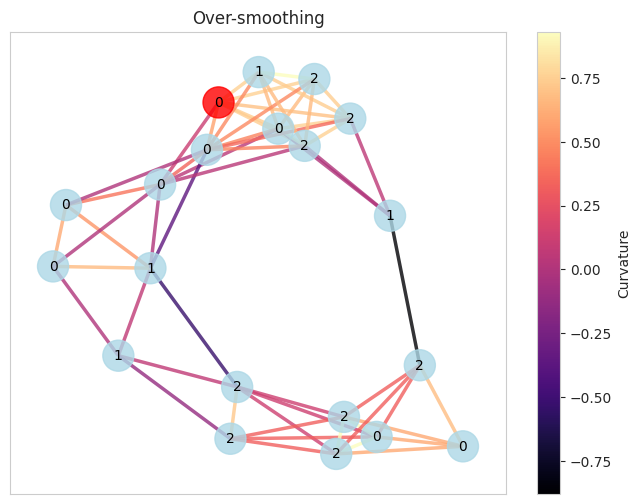

tensor([2, 0, 0, 0, 2, 2, 1, 0, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2])
1


In [ ]:
'''
Generate geometric graphs with diameter and clustering coefficient

'''
def generate_graph(diameter, clustering_coefficient, num_classes, num_nodes):

    while True:
        G = nx.random_geometric_graph(num_nodes, 0.4)
        if nx.is_connected(G):
            actual_diameter = nx.diameter(G)
            actual_clustering = nx.average_clustering(G)
            if actual_diameter >= diameter and actual_clustering >= clustering_coefficient:
                break


    if nx.is_connected(G):
      adj_matrix = nx.adjacency_matrix(G).toarray()
      adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
      labels = torch.randint(0, num_classes, (num_nodes,))

      eccentricities = nx.eccentricity(G) #find the target node, as the node with largest eccentricity
      root_node = max(eccentricities, key=eccentricities.get)

      label_counts = Counter(labels.numpy())
      max_freq = max(label_counts.values())
      tied_labels = [label for label, count in label_counts.items() if count == max_freq]
      majority_label = min(tied_labels)

      features = torch.zeros((num_nodes, num_classes))
      features[torch.arange(num_nodes), labels] = 1

    return adj_matrix, features, labels, majority_label, G, root_node




adj_matrix, features, labels, root_label, G, root_node = generate_graph(
    diameter=3,
    clustering_coefficient=0.2,
    num_classes=3,
    num_nodes=20)

curvature=get_curvature_labels(G)
print(labels)
visualize_graph(G, labels, root_label, root_node, curvature)
print(labels)
print(root_node)

In [ ]:
def create_dataset_smooth(num_samples, diameter, clustering_coefficient, num_classes, num_nodes):

    dataset = []
    for _ in range(num_samples):
        adj_matrix, features, labels, root_label, G, root_node = generate_graph(diameter, clustering_coefficient, num_classes, num_nodes)
        curvature= get_curvature_labels(G)
        dataset.append((adj_matrix, features, labels, root_label, root_node, curvature))
    return dataset


In [ ]:
def train_gnn_with_dataset_smooth(model, train_dataset, num_classes, epochs, learning_rate, device="cpu"):

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for adj_matrix, features, labels, root_label, root_node,curvature in train_dataset:
            adj_matrix = adj_matrix.to(device)
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(features, adj_matrix)
            #outputs = model(features, adj_matrix, curvature)

            # Extract root node prediction and true label
            root_prediction = outputs[root_node].unsqueeze(0)  # Root node is at index 0
            root_label = torch.tensor([root_label], device=device)  # True root label

            loss = loss_fn(root_prediction, root_label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataset)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return model

In [ ]:
def test_gnn_with_dataset_smooth(model, test_dataset, device="cpu"):

    model.eval()
    correct = 0

    for adj_matrix, features, labels, root_label, root_node, curvature in test_dataset:
        adj_matrix = adj_matrix.to(device)
        features = features.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            # Forward pass
            outputs= model(features, adj_matrix)
            #outputs = model(features, adj_matrix, curvature)

            root_prediction = outputs[root_node].argmax().item()
            root_label = torch.tensor([root_label], device=device)

            if root_prediction == root_label:
                correct += 1

    accuracy = correct / len(test_dataset)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return accuracy

In [ ]:
#Datasets:
num_classes = 5
input_dim = num_classes
hidden_dim = 8
output_dim = num_classes
epochs = 23
learning_rate = 0.001
num_train_samples = 1000
num_test_samples = 100
clustering_coefficient = 0.2

num_nodes = 20
smooth_accuracy= [ ]
iter = [ ]
diameter= 3
variances = []
device='cpu'

train_dataset = create_dataset_smooth(num_train_samples, diameter, clustering_coefficient, num_classes, num_nodes)
test_dataset = create_dataset_smooth(num_train_samples, diameter, clustering_coefficient, num_classes, num_nodes)



In [ ]:
smooth_accuracy= [ ]
diameter= 3
variances = []
learning_rate = 0.001
device = 'cpu'
epochs=40
for i in range(1,9):
  embedding_variances = []

  model = GINModule(input_dim, hidden_dim, output_dim, num_layers=i)

  trained_model= train_gnn_with_dataset_smooth(model, train_dataset, num_classes, epochs, learning_rate)
  test_accuracy = test_gnn_with_dataset_smooth(trained_model, test_dataset)


  for adj_matrix, features, labels, root_label, root_node, curvature in train_dataset:  #calculate the variances
          adj_matrix = adj_matrix.to(device)
          features = features.to(device)
          labels = labels.to(device)
          hidden_representation = model(features, adj_matrix,)
          normalized_hidden_representation = F.normalize(hidden_representation, p=2, dim=1)
          variance = torch.var(normalized_hidden_representation, dim=0).mean().item()
          embedding_variances.append(variance)

  avg_variance = sum(embedding_variances) / len(embedding_variances)
  variances.append(avg_variance)

  print('variance:', avg_variance)
  print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
  iter.append(i)

  smooth_accuracy.append(test_accuracy)

  print(smooth_accuracy)
  print(variances)

Epoch 1/40, Loss: 1.5378
Epoch 2/40, Loss: 1.4333
Epoch 3/40, Loss: 1.3579
Epoch 4/40, Loss: 1.3268
Epoch 5/40, Loss: 1.3140
Epoch 6/40, Loss: 1.3055
Epoch 7/40, Loss: 1.2982
Epoch 8/40, Loss: 1.2928
Epoch 9/40, Loss: 1.2854
Epoch 10/40, Loss: 1.2781
Epoch 11/40, Loss: 1.2715
Epoch 12/40, Loss: 1.2638
Epoch 13/40, Loss: 1.2569
Epoch 14/40, Loss: 1.2502
Epoch 15/40, Loss: 1.2440
Epoch 16/40, Loss: 1.2396
Epoch 17/40, Loss: 1.2347
Epoch 18/40, Loss: 1.2308
Epoch 19/40, Loss: 1.2270
Epoch 20/40, Loss: 1.2226
Epoch 21/40, Loss: 1.2194
Epoch 22/40, Loss: 1.2178
Epoch 23/40, Loss: 1.2161
Epoch 24/40, Loss: 1.2143
Epoch 25/40, Loss: 1.2128
Epoch 26/40, Loss: 1.2115
Epoch 27/40, Loss: 1.2111
Epoch 28/40, Loss: 1.2103
Epoch 29/40, Loss: 1.2082
Epoch 30/40, Loss: 1.2067
Epoch 31/40, Loss: 1.2058
Epoch 32/40, Loss: 1.2058
Epoch 33/40, Loss: 1.2042
Epoch 34/40, Loss: 1.2033
Epoch 35/40, Loss: 1.2021
Epoch 36/40, Loss: 1.2015
Epoch 37/40, Loss: 1.1998
Epoch 38/40, Loss: 1.1990
Epoch 39/40, Loss: 1.